In [85]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import *

In [86]:
#from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import mean_squared_error
#from math import sqrt
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
# import lightgbm as lgb
from sklearn.linear_model import LogisticRegression

In [87]:
MISSING = -9999

In [88]:
df = pd.read_csv("../data/processed/data_encoded.csv")

In [89]:
df.shape

(39325, 1562)

In [90]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")
df_test = df[df["test"] == 1].drop(columns=["test"]).set_index("id")

In [91]:
X = df_train.drop(columns=["satisfied"])
y = df_train["satisfied"]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)

In [93]:
X_train["satisfied"] = y_train

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
X_test["satisfied"] = y_test

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [95]:
X_final = df_test.drop(columns=["satisfied"])

In [96]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_final = X_final.reset_index(drop=True)

In [97]:
X_train.shape

(21056, 1560)

In [98]:
X_test.shape

(9024, 1560)

In [99]:
X_final.shape

(9245, 1559)

In [100]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [101]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [102]:
class LightGBMWrapper(object):
    def __init__(self, seed=0, params=None):
        params['seed'] = seed
        self.params = params

    def train(self, x_train, y_train):
        dtrain = lgb.Dataset(x_train,label=y_train)
        bst = lgb.cv(self.params, dtrain, num_boost_round=1000, nfold=3, early_stopping_rounds=30) #cv寻找较优的迭代次数
        self.lgbc = lgb.train(self.params,dtrain,num_boost_round=len(bst['auc-mean']))

    def predict(self, x):
        return self.lgbc.predict(np.array(x))

In [103]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        res = xgb.cv(self.param, dtrain, num_boost_round=2000, nfold=3, stratified=True,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True) #cv寻找较优的迭代次数
        self.nrounds = res.shape[0]
        #print (res)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [104]:
class ModelStacking():
    def __init__(self, train_data, test_data, online_data, predictors, models=['et','rf','xgb','cb','lgb'], dep='y',nfolds=5, seed=0):
        '''
        train_data: DataFrame, 训练集;
        test_data: DataFrame, 测试集;
        online_data: DataFrame, 待预测样本;
        predictors：list or array, 待训练变量名;
        models: list, 模型名称;
        dep: str, y值;
        nfolds: int, stacking的折数;
        seed: int, 随机种子;
        '''
        self.train_data = train_data #训练集
        self.test_data = test_data #测试集（带label)
        self.online_data = online_data #需要预测的数据集（label未知）
        self.dep = dep #y的标签名称
        self.nfolds = nfolds #k折
        self.predictors = predictors #待训练的变量名称list
        self.seed = seed #随机种子
        self.ntrain = self.train_data.shape[0]
        self.ntest = self.test_data.shape[0]
        self.nonline = self.online_data.shape[0]
        self.models = models #模型名称list
        
        self.params_list() #初始化各模型的参数

    def get_oof(self,clf):
        '''
        clf: model wrapper object;
        :产生下一层训练的变量;
        '''
        kf = KFold(n_splits = self.nfolds, shuffle=True, random_state=0)
        oof_train = np.zeros((self.ntrain,)) #生成训练集预测结果的容器
        oof_test = np.zeros((self.ntest,)) #生成测试集预测结果的容器
        oof_online = np.zeros((self.nonline,)) #生成待预测集预测结果的容器
        oof_test_skf = np.empty((self.nfolds, self.ntest)) #生成测试集多折预测结果的容器
        oof_online_skf = np.empty((self.nfolds, self.nonline)) #生成待预测集集多折预测结果的容器
    
        for i, (train_index, test_index) in enumerate(kf.split(self.train_data)):
            x_tr = self.train_data.loc[train_index,self.predictors]
            y_tr = self.train_data[self.dep].loc[train_index]
            x_te = self.train_data.loc[test_index,self.predictors]
    
            clf.train(x_tr, y_tr) #折数训练

            oof_train[test_index] = clf.predict(x_te) #第i折中训练预测结果保存
            
            oof_test_skf[i, :] = clf.predict(self.test_data[self.predictors]) #预测测试集
            
            oof_online_skf[i,:] = clf.predict(self.online_data[self.predictors]) #预测待预测集
    
        oof_test[:] = oof_test_skf.mean(axis=0) #取平均
        oof_online[:] = oof_online_skf.mean(axis=0) #取平均
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_online.reshape(-1, 1)

    def params_list(self):
        '''
        : 初始化模型参数
        '''
        et_params = {
            'n_jobs': 1,
            'n_estimators': 100,
            'max_features': 'sqrt',
            'max_depth': 8,
            'min_samples_leaf': 2,
        }
        
        lr_params = {
            'n_jobs': 4,
            'solver': 'liblinear',
            'penalty': 'l1',
            'C': 0.21,
        }
        
        rf_params = {
            'n_jobs': 4,
            'n_estimators': 100,
            'max_features': 'sqrt',
            'max_depth': 8,
            'min_samples_leaf': 2,
        }
        
        xgb_params ={
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'max_depth': 5,
            'subsample': 1.0,
            'scale_pos_weight': 1.0,
            'colsample_bytree': 0.5,
            'colsample_bynode': 1.0,
            'colsample_bylevel': 0.5,
            'eta': 0.1,
            'lambda': 10,
            'min_child_weight': 1,
            'seed': 0,
            'nthread': 4,
            'silent': 1,
            'eval_metric': 'auc'
        }
        
        cb_params = {
            'iterations': 300,
            'learning_rate': 0.1,
            'depth': 2,
            'l2_leaf_reg': 8,
            'bootstrap_type': 'Bernoulli',
            'subsample': 0.7,
            'scale_pos_weight': 5,
            'eval_metric': 'AUC',
            'od_type': 'Iter',
            'allow_writing_files': False
        }
        
#         cb_params = {
#             'iterations': 30,
#             'learning_rate': 0.5,
#             'depth': 3,
#             'l2_leaf_reg': 40,
#             'bootstrap_type': 'Bernoulli',
#             'subsample': 0.7,
#             'scale_pos_weight': 5,
#             'eval_metric': 'AUC',
#             'od_type': 'Iter',
#             'allow_writing_files': False
#         }
        
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_weight': 1,
            'num_leaves': 2 ** 5,
            'lambda_l2': 10,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'seed': 0,
            'colsample_bytree': 0.8,
            'nthread': 4
        }
        
        self.params_dic = {}
        self.params_dic['et_params'] = et_params
        self.params_dic['rf_params'] = rf_params
        self.params_dic['xgb_params'] = xgb_params
        self.params_dic['cb_params'] = cb_params
        self.params_dic['lgb_params'] = lgb_params
        self.params_dic['lr_params'] = lr_params

    def model_train_predict(self):
        '''
        ：针对选定的模型进行训练，并针对每个数据集产生预测结果
        '''
        self.build_models = {}
        self.models_oof_return = {}
        for mm in self.models:
            if mm == 'et':
                self.build_models['et'] = SklearnWrapper(clf=ExtraTreesClassifier, seed=self.seed, params=self.params_dic['et_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['et'])
                self.models_oof_return['et'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('et-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],et_oof_train))
            elif mm == 'rf':
                self.build_models['rf'] = SklearnWrapper(clf=RandomForestClassifier, seed=self.seed, params=self.params_dic['rf_params'])
                rf_oof_train, rf_oof_test, rf_oof_online = self.get_oof(self.build_models['rf'])
                self.models_oof_return['rf'] = [rf_oof_train, rf_oof_test, rf_oof_online]
                print ('rf-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],rf_oof_train))
            elif mm == 'cb':
                self.build_models['cb'] = CatboostWrapper(clf= CatBoostClassifier, seed=self.seed, params=self.params_dic['cb_params'])
                cb_oof_train, cb_oof_test, cb_oof_online = self.get_oof(self.build_models['cb'])
                self.models_oof_return['cb'] = [cb_oof_train, cb_oof_test, cb_oof_online]
                print ('cb-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],cb_oof_train))
            elif mm == 'lgb':
                self.build_models['lgb'] = LightGBMWrapper(seed=self.seed, params=self.params_dic['lgb_params'])
                lgb_oof_train, lgb_oof_test, lgb_oof_online = self.get_oof(self.build_models['lgb'])
                self.models_oof_return['lgb'] = [lgb_oof_train, lgb_oof_test, lgb_oof_online]
                print ('lgb-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],lgb_oof_train))
            elif mm == 'xgb':
                self.build_models['xgb'] = XgbWrapper(seed=self.seed, params=self.params_dic['xgb_params'])
                xgb_oof_train, xgb_oof_test, xcb_oof_online = self.get_oof(self.build_models['xgb'])
                self.models_oof_return['xgb'] = [xgb_oof_train, xgb_oof_test, xcb_oof_online]
                print ('xgb-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],xgb_oof_train))
            elif mm == 'lr':
                self.build_models['lr'] = SklearnWrapper(clf=LogisticRegression, seed=self.seed, params=self.params_dic['lr_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['lr'])
                self.models_oof_return['lr'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('lr-CV AUC is %.3f'%roc_auc_score(self.train_data[self.dep],et_oof_train))

    def stacking(self):
        '''
        : 针对上一层产出的结果再次训练，并产生待预测样本的预测概率结果;
        '''
        self.model_train_predict() #训练并预测
        #组合上面每个模型的预测结果
        for i in range(len(self.models)):
            if i == 0:
                x_train = self.models_oof_return[self.models[i]][0]
                x_test = self.models_oof_return[self.models[i]][1]
                x_online = self.models_oof_return[self.models[i]][2]
            else:
                x_train = np.concatenate((x_train,self.models_oof_return[self.models[i]][0]), axis=1)
                x_test = np.concatenate((x_test,self.models_oof_return[self.models[i]][1]), axis=1)
                x_online = np.concatenate((x_online,self.models_oof_return[self.models[i]][2]), axis=1)
        #用xgb作为最终的分类器
        dtrain = xgb.DMatrix(x_train, label=self.train_data[self.dep])
        dtest = xgb.DMatrix(x_test)
        donline = xgb.DMatrix(x_online)
        xgb_params = {
            'seed': 0,
            'colsample_bytree': 0.8,
            'silent': 1,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'objective': 'binary:logistic',
            'max_depth': 4,
            'num_parallel_tree': 1,
            'min_child_weight': 1,
            'eval_metric': 'auc'
        }
        res = xgb.cv(xgb_params, dtrain, num_boost_round=10, nfold=4, seed=self.seed, stratified=False,
             early_stopping_rounds=25, verbose_eval=10, show_stdv=True) #cv寻找合适的迭代次数
        best_nrounds = res.shape[0] - 1
        cv_mean = res.iloc[-1, 0]
        cv_std = res.iloc[-1, 1]        
        print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std)) #cv效果
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
        dtest_prob = gbdt.predict(dtest)
        donline_prob = gbdt.predict(donline)
        print ('Ensemble-test %.3f'%roc_auc_score(self.test_data[self.dep],dtest_prob)) #测试集效果
        return donline_prob

In [ ]:
ms = ModelStacking(X_train,
                   X_test,
                   X_final,
                   list(X_train.columns[:-1]),
                   models = [
#                        'et',
                       'rf',
                       'lr',
                       'cb',
                       'xgb',
                   ],
                   dep='satisfied')
c = ms.stacking()

rf-CV AUC is 0.863


/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinea

lr-CV AUC is 0.882
0:	total: 11.2ms	remaining: 3.36s
1:	total: 18.4ms	remaining: 2.75s
2:	total: 26ms	remaining: 2.57s
3:	total: 33.3ms	remaining: 2.46s
4:	total: 41.4ms	remaining: 2.44s
5:	total: 49.4ms	remaining: 2.42s
6:	total: 57.1ms	remaining: 2.39s
7:	total: 64.2ms	remaining: 2.34s
8:	total: 70.5ms	remaining: 2.28s
9:	total: 78ms	remaining: 2.26s
10:	total: 85.1ms	remaining: 2.24s
11:	total: 92.2ms	remaining: 2.21s
12:	total: 98.7ms	remaining: 2.18s
13:	total: 106ms	remaining: 2.17s
14:	total: 112ms	remaining: 2.13s
15:	total: 119ms	remaining: 2.11s
16:	total: 126ms	remaining: 2.1s
17:	total: 133ms	remaining: 2.08s
18:	total: 141ms	remaining: 2.08s
19:	total: 148ms	remaining: 2.08s
20:	total: 156ms	remaining: 2.07s
21:	total: 164ms	remaining: 2.07s
22:	total: 171ms	remaining: 2.06s
23:	total: 178ms	remaining: 2.04s
24:	total: 184ms	remaining: 2.02s
25:	total: 190ms	remaining: 2.01s
26:	total: 197ms	remaining: 1.99s
27:	total: 204ms	remaining: 1.99s
28:	total: 216ms	remaining: 2.0

261:	total: 2.06s	remaining: 299ms
262:	total: 2.07s	remaining: 291ms
263:	total: 2.08s	remaining: 283ms
264:	total: 2.09s	remaining: 276ms
265:	total: 2.09s	remaining: 268ms
266:	total: 2.1s	remaining: 260ms
267:	total: 2.11s	remaining: 252ms
268:	total: 2.12s	remaining: 244ms
269:	total: 2.13s	remaining: 236ms
270:	total: 2.13s	remaining: 228ms
271:	total: 2.14s	remaining: 220ms
272:	total: 2.15s	remaining: 212ms
273:	total: 2.15s	remaining: 205ms
274:	total: 2.16s	remaining: 197ms
275:	total: 2.17s	remaining: 189ms
276:	total: 2.18s	remaining: 181ms
277:	total: 2.19s	remaining: 173ms
278:	total: 2.19s	remaining: 165ms
279:	total: 2.2s	remaining: 157ms
280:	total: 2.21s	remaining: 149ms
281:	total: 2.22s	remaining: 142ms
282:	total: 2.23s	remaining: 134ms
283:	total: 2.23s	remaining: 126ms
284:	total: 2.24s	remaining: 118ms
285:	total: 2.25s	remaining: 110ms
286:	total: 2.26s	remaining: 102ms
287:	total: 2.27s	remaining: 94.8ms
288:	total: 2.28s	remaining: 86.8ms
289:	total: 2.29s	re

201:	total: 1.82s	remaining: 885ms
202:	total: 1.84s	remaining: 878ms
203:	total: 1.85s	remaining: 870ms
204:	total: 1.86s	remaining: 860ms
205:	total: 1.86s	remaining: 850ms
206:	total: 1.87s	remaining: 841ms
207:	total: 1.88s	remaining: 832ms
208:	total: 1.89s	remaining: 824ms
209:	total: 1.9s	remaining: 815ms
210:	total: 1.91s	remaining: 807ms
211:	total: 1.92s	remaining: 797ms
212:	total: 1.93s	remaining: 788ms
213:	total: 1.94s	remaining: 778ms
214:	total: 1.95s	remaining: 769ms
215:	total: 1.95s	remaining: 760ms
216:	total: 1.96s	remaining: 751ms
217:	total: 1.97s	remaining: 741ms
218:	total: 1.98s	remaining: 732ms
219:	total: 1.99s	remaining: 724ms
220:	total: 2s	remaining: 714ms
221:	total: 2.01s	remaining: 705ms
222:	total: 2.02s	remaining: 696ms
223:	total: 2.03s	remaining: 688ms
224:	total: 2.03s	remaining: 678ms
225:	total: 2.05s	remaining: 670ms
226:	total: 2.06s	remaining: 661ms
227:	total: 2.06s	remaining: 652ms
228:	total: 2.08s	remaining: 644ms
229:	total: 2.08s	remain

158:	total: 1.24s	remaining: 1.1s
159:	total: 1.25s	remaining: 1.09s
160:	total: 1.25s	remaining: 1.08s
161:	total: 1.26s	remaining: 1.07s
162:	total: 1.27s	remaining: 1.07s
163:	total: 1.28s	remaining: 1.06s
164:	total: 1.29s	remaining: 1.05s
165:	total: 1.29s	remaining: 1.04s
166:	total: 1.3s	remaining: 1.04s
167:	total: 1.31s	remaining: 1.03s
168:	total: 1.31s	remaining: 1.02s
169:	total: 1.32s	remaining: 1.01s
170:	total: 1.33s	remaining: 1s
171:	total: 1.34s	remaining: 995ms
172:	total: 1.34s	remaining: 988ms
173:	total: 1.35s	remaining: 980ms
174:	total: 1.36s	remaining: 973ms
175:	total: 1.37s	remaining: 964ms
176:	total: 1.38s	remaining: 957ms
177:	total: 1.38s	remaining: 948ms
178:	total: 1.39s	remaining: 940ms
179:	total: 1.4s	remaining: 933ms
180:	total: 1.41s	remaining: 924ms
181:	total: 1.41s	remaining: 917ms
182:	total: 1.42s	remaining: 909ms
183:	total: 1.43s	remaining: 902ms
184:	total: 1.44s	remaining: 895ms
185:	total: 1.45s	remaining: 888ms
186:	total: 1.46s	remainin

110:	total: 821ms	remaining: 1.4s
111:	total: 830ms	remaining: 1.39s
112:	total: 839ms	remaining: 1.39s
113:	total: 846ms	remaining: 1.38s
114:	total: 854ms	remaining: 1.37s
115:	total: 861ms	remaining: 1.37s
116:	total: 870ms	remaining: 1.36s
117:	total: 877ms	remaining: 1.35s
118:	total: 885ms	remaining: 1.34s
119:	total: 893ms	remaining: 1.34s
120:	total: 901ms	remaining: 1.33s
121:	total: 908ms	remaining: 1.32s
122:	total: 914ms	remaining: 1.31s
123:	total: 922ms	remaining: 1.31s
124:	total: 930ms	remaining: 1.3s
125:	total: 936ms	remaining: 1.29s
126:	total: 946ms	remaining: 1.29s
127:	total: 953ms	remaining: 1.28s
128:	total: 961ms	remaining: 1.27s
129:	total: 969ms	remaining: 1.27s
130:	total: 977ms	remaining: 1.26s
131:	total: 985ms	remaining: 1.25s
132:	total: 993ms	remaining: 1.25s
133:	total: 1s	remaining: 1.24s
134:	total: 1.01s	remaining: 1.23s
135:	total: 1.01s	remaining: 1.22s
136:	total: 1.03s	remaining: 1.22s
137:	total: 1.04s	remaining: 1.22s
138:	total: 1.04s	remaini

55:	total: 416ms	remaining: 1.81s
56:	total: 425ms	remaining: 1.81s
57:	total: 434ms	remaining: 1.81s
58:	total: 442ms	remaining: 1.8s
59:	total: 449ms	remaining: 1.8s
60:	total: 456ms	remaining: 1.79s
61:	total: 465ms	remaining: 1.78s
62:	total: 472ms	remaining: 1.77s
63:	total: 478ms	remaining: 1.76s
64:	total: 485ms	remaining: 1.75s
65:	total: 494ms	remaining: 1.75s
66:	total: 502ms	remaining: 1.74s
67:	total: 509ms	remaining: 1.74s
68:	total: 516ms	remaining: 1.73s
69:	total: 523ms	remaining: 1.72s
70:	total: 530ms	remaining: 1.71s
71:	total: 536ms	remaining: 1.7s
72:	total: 543ms	remaining: 1.69s
73:	total: 551ms	remaining: 1.68s
74:	total: 558ms	remaining: 1.67s
75:	total: 566ms	remaining: 1.67s
76:	total: 574ms	remaining: 1.66s
77:	total: 581ms	remaining: 1.65s
78:	total: 587ms	remaining: 1.64s
79:	total: 595ms	remaining: 1.64s
80:	total: 602ms	remaining: 1.63s
81:	total: 609ms	remaining: 1.62s
82:	total: 621ms	remaining: 1.62s
83:	total: 631ms	remaining: 1.62s
84:	total: 640ms	

cb-CV AUC is 0.892
[0]	train-auc:0.796666+0.000924289	test-auc:0.782469+0.00267727
[10]	train-auc:0.895023+0.00634115	test-auc:0.881687+0.00158783
[20]	train-auc:0.903818+0.00351713	test-auc:0.886907+0.00256819
[30]	train-auc:0.91023+0.00249564	test-auc:0.889511+0.00347416
[40]	train-auc:0.915131+0.00243248	test-auc:0.890788+0.00365144
[50]	train-auc:0.91984+0.00265366	test-auc:0.891401+0.00384311
[60]	train-auc:0.92434+0.00264834	test-auc:0.891949+0.00382081
[70]	train-auc:0.928312+0.00251964	test-auc:0.892306+0.0037815
[80]	train-auc:0.932002+0.00211265	test-auc:0.892558+0.00384629
[90]	train-auc:0.935368+0.00193626	test-auc:0.892794+0.00375085
[100]	train-auc:0.938568+0.00165154	test-auc:0.89284+0.00382604
[110]	train-auc:0.941348+0.00122528	test-auc:0.892887+0.00379793
[120]	train-auc:0.944242+0.00119175	test-auc:0.892798+0.00383949
[130]	train-auc:0.946752+0.000783592	test-auc:0.892777+0.00385568
[0]	train-auc:0.79471+0.00171377	test-auc:0.781895+0.00229095
[10]	train-auc:0.8951+0

In [ ]:
plt.plot(ms.models_oof_return['xgb'][1], ms.models_oof_return['lr'][1], '.')

In [ ]:
c

In [79]:
test_ids = pd.read_csv("../data/interim/test.csv")["id"]

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,6,10,12,21,24,35,85,87,88,89,100,124,126,127,128,130,131,133,166,172,177,193,194,195,205,206,207,220,222,228,229,230,240,257,258,260,261,262) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [78]:
result = pd.DataFrame()

In [81]:
result["Id"] = test_ids

In [82]:
result["Predicted"] = c

In [84]:
result.to_csv("../data/result/result_03_07_submission2.csv", index=False)

In [83]:
result

,Id,Predicted
0,14061,0.288857
1,16467,0.265743
2,25725,0.733566
3,9100,0.644436
4,32597,0.515512
...,...,...
9240,31430,0.730722
9241,3876,0.544377
9242,20710,0.639270
9243,26015,0.639105


In [26]:
# X_train

In [81]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=0.21)

In [82]:
model.fit(X_train.drop(columns=["satisfied"]), X_train["satisfied"])

LogisticRegression(C=0.21, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
y_pred = model.predict_proba(X_test.drop(columns=["satisfied"]))

In [84]:
roc_auc_score(X_test["satisfied"], y_pred[:,1])

0.8743625260766862

In [79]:
param_grid = {
    'penalty' : ['l1'],
    'C' : np.linspace(0.2, 0.4, 20),
    'solver' : ['liblinear'],
}


# Create grid search object

clf = GridSearchCV(LogisticRegression(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train.drop(columns=["satisfied"]), X_train["satisfied"])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.8min finished


In [80]:
best_clf.best_params_

{'C': 0.2105263157894737, 'penalty': 'l1', 'solver': 'liblinear'}

In [12]:
params = {
    'subsample': 1.0,
    'scale_pos_weight': 1.0,
    'max_depth': 5,
    'colsample_bytree': 0.5,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 0.5
}

In [13]:
final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    objective='binary:logistic',
    silent=True, 
    missing=MISSING,
    nthread=8,
    **params
    )

In [14]:
final_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1.0, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-9999, n_estimators=100, n_jobs=1,
              nthread=8, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.0, seed=None,
              silent=True, subsample=1.0, verbosity=1)

In [15]:
y_pred_train = final_model.predict(X_train)
y_prob_train = final_model.predict_proba(X_train)[:,1]

In [16]:
y_pred_test = final_model.predict(X_test)
y_prob_test = final_model.predict_proba(X_test)[:,1]

In [17]:
roc_auc_score(y_test, y_prob_test), roc_auc_score(y_train, y_prob_train)

(0.8899624722473075, 0.9317559897870336)

In [ ]:
(0.8899624722473075, 0.9317559897870336)

In [24]:
(0.8901941061759845, 0.9386534084249205)  #5

(0.8901941061759845, 0.9386534084249205)

In [25]:
(0.8901553362068626, 0.9203028581243273) #4

(0.8901553362068626, 0.9203028581243273)

In [26]:
(0.8896688507329076, 0.9068574909384938) #3

(0.8896688507329076, 0.9068574909384938)

In [27]:
(0.8879588067229542, 0.8971857360901431) #2

(0.8879588067229542, 0.8971857360901431)

In [28]:
y_pred_final = final_model.predict(X_final)
y_prob_final = final_model.predict_proba(X_final)[:,1]

In [29]:
df_result = pd.DataFrame(y_prob_final, columns=["Predicted"])

In [30]:
df_result["Id"] = df_test.index

In [31]:
df_result[["Id", "Predicted"]]

,Id,Predicted
0,14061,0.064110
1,16467,0.107665
2,25725,0.930857
3,9100,0.860247
4,32597,0.567849
...,...,...
9240,31430,0.920340
9241,3876,0.675523
9242,20710,0.732794
9243,26015,0.713012


In [32]:
df_result[["Id", "Predicted"]].to_csv("../data/result/result_03_05_submission2.csv", index=False)

In [33]:
y_prob_test

array([0.27419066, 0.2696268 , 0.05794397, ..., 0.24994688, 0.07023645,
       0.06697793], dtype=float32)

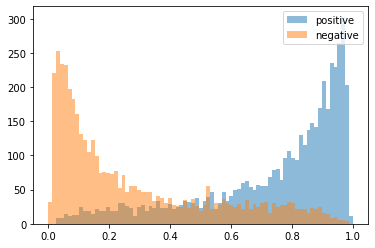

In [34]:
pos = y_prob_test[y_test.astype(bool).values]
neg = y_prob_test[~(y_test.astype(bool).values)]

bins = np.linspace(0, 1, 80)

plt.hist(pos, bins, alpha=0.5, label='positive')
plt.hist(neg, bins, alpha=0.5, label='negative')
plt.legend(loc='upper right')
plt.show()

In [348]:
df_original = pd.read_csv("../data/interim/train.csv")

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,4,6,10,12,18,24,35,56,57,65,85,86,87,88,89,98,99,100,105,124,125,126,127,128,130,131,133,166,171,172,192,193,194,195,204,205,206,207,228,229,230,240,256,257,258,259,260,261,262) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [374]:
df_ori = df_original.set_index("id").loc[X_train.index]

In [375]:
df_ori["pred"] = y_pred_train
df_ori["prob"] = y_prob_train

In [376]:
df_ori["correct"] = (df_ori["satisfied"] == df_ori["pred"]).astype(int)

In [377]:
df_ori

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v266,v267,v268,v269,v270,cntry,satisfied,pred,prob,correct
id,,,,,,,,,,,,,,,,,,,,,
16436,7,2,44,12040,.a,1,2,2,2,1,...,.a,.a,.a,NaN,NaN,NO,1,1.0,0.865028,1
5416,8,1,49,12020,.a,1,1,2,2,1,...,.a,.a,.a,.a,.a,FI,1,1.0,0.984691,1
39101,1,2,72,13060,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,PT,0,0.0,0.035139,1
28286,5,2,71,11030,.a,2,2,2,2,1,...,.a,.a,.a,.a,NaN,GB,0,0.0,0.110533,1
3419,5,2,73,11080,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,IE,0,0.0,0.103392,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,1,2,71,11010,11010,2,2,2,2,1,...,.a,.a,.a,.a,NaN,AT,0,0.0,0.069247,1
16426,2,2,57,15040,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,HU,0,0.0,0.120433,1
14088,0,2,36,11050,11050,2,1,2,2,1,...,2010,.a,.a,.a,NaN,FR,0,0.0,0.454509,1


In [353]:
temp = df_ori.groupby("cntry").agg({"satisfied": ["mean", "count"], "correct": ["mean"]})
temp

satisfied         correct
           mean count      mean
cntry                          
AT     0.565036   961  0.862643
BE     0.750000     4  1.000000
CH     0.730178   845  0.871006
CZ     0.381435  1185  0.854008
DE     0.607143  1652  0.831114
DK     0.813760   843  0.920522
EE     0.358156  1128  0.836879
ES     0.458969  1048  0.818702
FI     0.724826  1152  0.863715
FR     0.399236  1047  0.812798
GB     0.509646  1244  0.845659
HU     0.240000   950  0.874737
IE     0.453210  1293  0.813612
IL     0.571530  1405  0.839146
LT     0.263993  1197  0.878864
NL     0.633523  1056  0.856061
NO     0.712435   772  0.869171
PL     0.483982   874  0.839817
PT     0.271429   700  0.872857
SE     0.692383  1024  0.865234
SI     0.437870   676  0.823964

In [354]:
hapiness = temp["satisfied"]["mean"]
correctness = temp["correct"]["mean"]
size = temp["satisfied"]["count"]

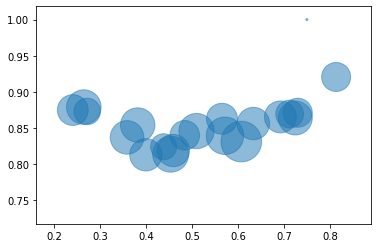

In [355]:
plt.scatter(hapiness, correctness, s=size, alpha=0.5)

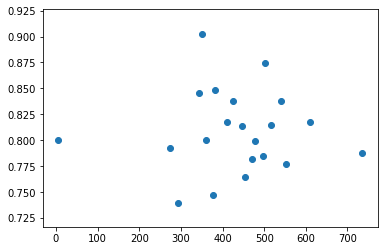

In [267]:
plt.scatter(size, correctness)

In [268]:
temp[temp["correct"]["mean"] < 0.8]

satisfied         correct
           mean count      mean
cntry                          
CZ     0.413655   498  0.785141
DE     0.599185   736  0.788043
EE     0.341004   478  0.799163
ES     0.521186   472  0.781780
FR     0.430769   455  0.764835
IE     0.503623   552  0.777174
PL     0.484043   376  0.747340
PT     0.318493   292  0.739726
SI     0.364964   274  0.791971

In [269]:
bad = temp[(temp["satisfied"]["mean"] > 0.3) & (temp["satisfied"]["mean"] < 0.6)].index

In [272]:
bad_ind = df_ori[df_ori["cntry"].isin(bad)].index

In [273]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")

In [276]:
df_train = df_train.loc[bad_ind]

In [277]:
X = df_train.drop(columns=["satisfied"])
y = df_train["satisfied"]

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1001)
# X_train_id, X_test_id, _, _ = train_test_split(X_id, y, test_size=0.30, random_state=1001)

params = {
    'subsample': 1.0,
    'scale_pos_weight': 1.0,
    'max_depth': 2,
    'colsample_bytree': 0.5,
    'colsample_bynode': 1.0,
    'colsample_bylevel': 0.5
}

final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    objective='binary:logistic',
    silent=True, 
    missing=MISSING,
    nthread=8,
    **params
    )


final_model.fit(X_train, y_train)

y_pred_train = final_model.predict(X_train)
y_prob_train = final_model.predict_proba(X_train)[:,1]

y_pred_test = final_model.predict(X_test)
y_prob_test = final_model.predict_proba(X_test)[:,1]

In [285]:
roc_auc_score(y_test, y_prob_test), roc_auc_score(y_train, y_prob_train)

(0.8755794913603105, 0.8904912771560237)

In [287]:
df_ori2 = df_original.set_index("id").loc[X_test.index]

In [288]:
df_ori2["pred"] = y_pred_test
df_ori2["prob"] = y_prob_test

In [289]:
df_ori2["correct"] = (df_ori2["satisfied"] == df_ori2["pred"]).astype(int)

In [290]:
df_ori2

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v266,v267,v268,v269,v270,cntry,satisfied,pred,prob,correct
id,,,,,,,,,,,,,,,,,,,,,
23751,3,2,26,11080,.a,1,2,2,2,1,...,2011,.a,.a,.a,.a,IE,1,1.0,0.861591,1
25617,2,2,47,11010,11010,1,2,2,2,1,...,.a,.a,.a,.a,NaN,AT,1,0.0,0.248110,0
18832,5,2,35,41030,.a,2,2,2,2,2,...,.a,.a,.a,.a,NaN,GB,0,0.0,0.058236,1
12235,9,2,33,15020,.a,2,1,2,2,1,...,.a,.a,NaN,NaN,NaN,CZ,1,1.0,0.863148,1
22091,0,3,54,11080,.a,2,2,2,2,1,...,1988,.a,.a,.a,.a,IE,1,1.0,0.757092,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23529,1,2,58,13070,13990,1,2,1,2,1,...,.a,.a,.a,.a,.a,ES,0,0.0,0.428250,1
2441,0,2,47,43000,.a,1,2,2,2,2,...,.a,.a,.a,.a,.a,PT,0,1.0,0.637797,0
14431,0,3,61,13060,.a,2,2,2,2,1,...,.a,.a,.a,.a,.a,PT,0,0.0,0.210856,1


In [291]:
temp = df_ori2.groupby("cntry").agg({"satisfied": ["mean", "count"], "correct": ["mean"]})
temp

satisfied         correct
           mean count      mean
cntry                          
AT     0.533835   133  0.834586
BE     0.500000     2  1.000000
CZ     0.356061   132  0.810606
DE     0.580357   224  0.776786
EE     0.324841   157  0.821656
ES     0.576923   130  0.815385
FR     0.421053   152  0.789474
GB     0.557047   149  0.825503
IE     0.480769   156  0.794872
PL     0.491379   116  0.732759
PT     0.298851    87  0.770115
SI     0.379310    87  0.793103

In [ ]:
hapiness = temp["satisfied"]["mean"]
correctness = temp["correct"]["mean"]
size = temp["satisfied"]["count"]

In [ ]:
plt.scatter(hapiness, correctness, s=size, alpha=0.5)

In [ ]:
plt.scatter(size, correctness)

In [ ]:
temp[temp["correct"]["mean"] < 0.8]